Tesseract Overview
-----------------------

This notebook is supposed to provide a brief overview over the Tesseract framework (and might be later adapted to Transcend as well).


    ├── tesseract             <- Main folder
    │   ├── mock.py           <- Module for generating test distributions for use with Tesseract
    │   ├── evaluation.py     <- This is the class where the magic happens  ;)
    │   ├── metrics.py        <- Various methods to calculate and output metrics (including AUT)
    │   └── ...

## Running this Notebook 

1. Run `make mamadroid` to pull the necessary data files. 
2. Reproduce Drebin graph from paper (Figure 5)

---

In [1]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'mamadroidPackages-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'mamadroidPackages-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'mamadroidPackages-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

### Visualise the temporal distribution of the dataset

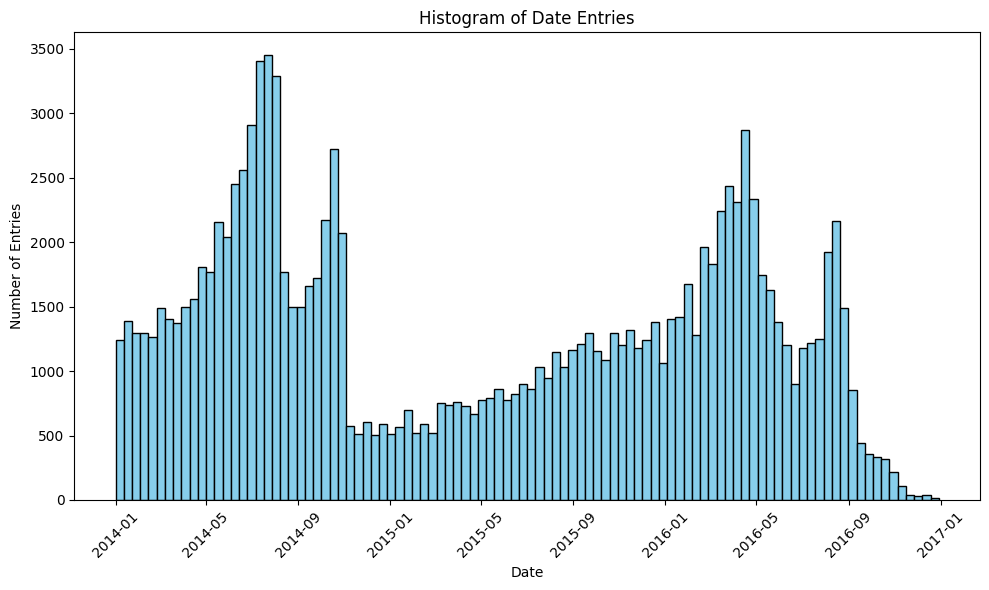

In [2]:
plt.figure(figsize=(10, 6))
plt.hist(t, bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
print(f"The earliest timestamp in the dataset is {t.min()}")
print(f"The latest timestamp in the dataset is {t.max()}")

The earliest timestamp in the dataset is 2014-01-01 00:25:40
The latest timestamp in the dataset is 2016-12-29 15:17:46


### Partition the dataset 

For an explanation of what `time_aware_train_test_split()` does, please check
the `tesseract-reproduce-drebin.ipnyb` file.

In [4]:
from tesseract import evaluation, temporal, metrics

# Partition dataset
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=101, max_depth=64, random_state=42)

results = evaluation.fit_predict_update(clf, *splits)
    
metrics.print_metrics(results)
    
# View AUT(F1, 24 months) as a measure of robustness over time 
print(metrics.aut(results, 'f1'))

22it [10:10, 27.77s/it]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
23it [10:10, 26.56s/it]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
24it [10:11, 25.46s/it]

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

F1 AUT: 0.3040675547613819
Recall AUT: 0.20115420756594385
Precision AUT: 0.8245817398165892


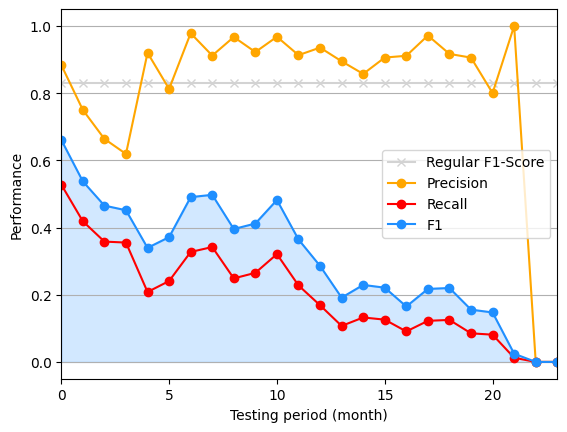

In [7]:
print(f"F1 AUT: {metrics.aut(results, 'f1')}")
print(f"Recall AUT: {metrics.aut(results, 'recall')}")
print(f"Precision AUT: {metrics.aut(results, 'precision')}")

from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

# Add the F1-Score when doing regular splitting to the plot
regular_f1_score = [0.83] * 24

plot(regular_f1_score, marker='x', color='lightgray')
plot(results['precision'], marker='o', color=pendleyellow)
plot(results['recall'], marker='o', color='red')
plot(results['f1'], marker='o', color=pendleblue)
fill_between(np.arange(0, 24), results['f1'], alpha=0.2, color=pendleblue)
legend(['Regular F1-Score', 'Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')